In [4]:
pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as stats

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from feature_engine.outliers import Winsorizer

from tensorflow import keras
from keras.callbacks import TensorBoard 

from sklearn.model_selection import train_test_split
from feature_engine import imputation as mdi

pd.options.display.max_columns = None

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

# Jupyter Notebook'un zekasını etkinleştirir.
%config IPCompleter.greedy=True

# Tüm içerikleri göstermeyi sağlar. 
pd.set_option('display.max_colwidth', None)

import tensorflow_decision_forests as tfdf

In [6]:
# verileri yükledik
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [7]:
# id koloundaki değerlerin hepsi farklı olduğundan işimize yaramayacaktır bu yüzden çıkartıldı
train_df = train_df.drop('Id', axis=1)

In [8]:
# train tablosuna dair bilgiler
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_32/2000694187.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


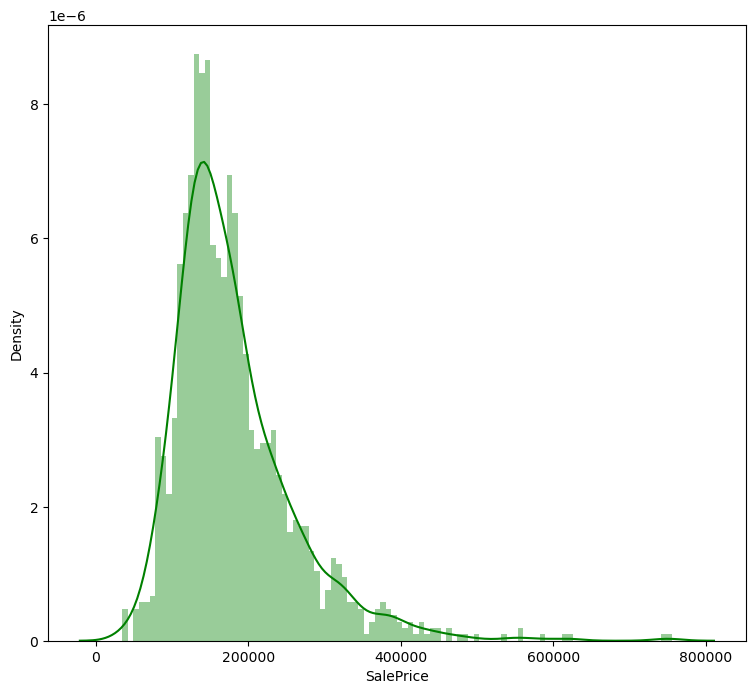

In [9]:
# satış fiyatlarının dağılım grafiği
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [11]:
# verinin eğitim ve doğrulama olarak ayrılması (%70 eğitim %30 doğrulama yapıldı)
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_pd, valid_pd = split_dataset(train_df)

In [12]:
# tfdf modeli için verinin ayarlanması
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [13]:
# random forest modelinin oluşturulması

rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmp_3cf7tg0 as temporary training directory


In [14]:
# modelinin eğitiminin yapılması
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:06.188636. Found 996 examples.
Training model...


[INFO 23-06-07 19:30:34.0574 UTC kernel.cc:1242] Loading model from path /tmp/tmp_3cf7tg0/model/ with prefix 72b47b9d0da74db9
[INFO 23-06-07 19:30:34.2397 UTC decision_forest.cc:660] Model loaded with 300 root(s), 94952 node(s), and 74 input feature(s).
[INFO 23-06-07 19:30:34.2397 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-07 19:30:34.2398 UTC kernel.cc:1074] Use fast generic engine


Model trained in 0:00:01.490347
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


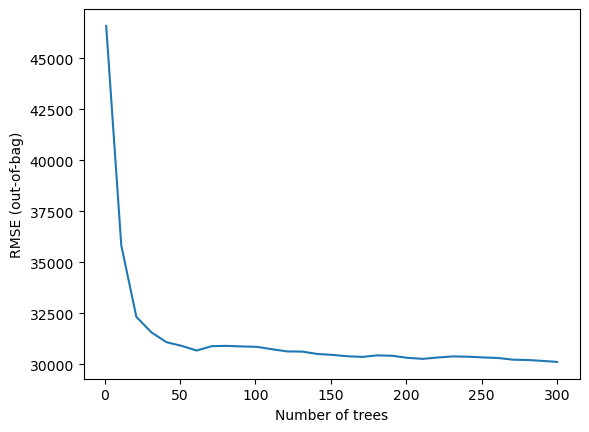

In [15]:
# modelin sonucunda çıkan kayıbın görselleştirilmesi
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [16]:
# en iyi 12 öznitelik ile oluşan çıktı (en iyi 12 özelliği kullanarak yukarıdaki modeli tekrar eğiticeğim)

# en iyi özniteliklerin bulunması
inspector = rf.make_inspector()
inspector.evaluation()

inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 104.0),
 ("Neighborhood" (4; #59), 42.0),
 ("ExterQual" (4; #22), 38.0),
 ("GarageCars" (1; #32), 37.0),
 ("GrLivArea" (1; #38), 32.0),
 ("GarageArea" (1; #31), 14.0),
 ("TotalBsmtSF" (1; #73), 13.0),
 ("KitchenQual" (4; #44), 9.0),
 ("1stFlrSF" (1; #0), 3.0),
 ("YearBuilt" (1; #76), 3.0),
 ("BsmtQual" (4; #14), 2.0),
 ("BsmtFinSF1" (1; #8), 1.0),
 ("Foundation" (4; #28), 1.0),
 ("FullBath" (1; #29), 1.0)]

In [17]:
# Sadece en iyi öz niteliklerin alınması
train_ds_best10 = train_pd[["OverallQual","Neighborhood","GarageCars","ExterQual","GrLivArea",
                          "BsmtQual","YearBuilt","KitchenQual","GarageArea","TotalBsmtSF",
                          "1stFlrSF","GarageYrBlt","SalePrice"]].copy() 

valid_ds_best10 = valid_pd[["OverallQual","Neighborhood","GarageCars","ExterQual","GrLivArea",
                          "BsmtQual","YearBuilt","KitchenQual","GarageArea","TotalBsmtSF",
                          "1stFlrSF","GarageYrBlt","SalePrice"]].copy() 

In [18]:
# verinin model için hazırlanması
label = 'SalePrice'
train_ds_best10 = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_best10, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds_best10 = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_best10, label=label, task = tfdf.keras.Task.REGRESSION)

In [19]:
# modelin oluşturulması ve eğitimi
rf_best10 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf_best10.compile(metrics=["mse"])

rf_best10.fit(x=train_ds_best10)

Use /tmp/tmp1x9s7flo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.229151. Found 996 examples.
Training model...
Model trained in 0:00:00.592184
Compiling model...


[INFO 23-06-07 19:32:01.6341 UTC kernel.cc:1242] Loading model from path /tmp/tmp1x9s7flo/model/ with prefix c1e80f76e925484b
[INFO 23-06-07 19:32:01.8066 UTC decision_forest.cc:660] Model loaded with 300 root(s), 94218 node(s), and 12 input feature(s).
[INFO 23-06-07 19:32:01.8067 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-07 19:32:01.8067 UTC kernel.cc:1074] Use fast generic engine


Model compiled.


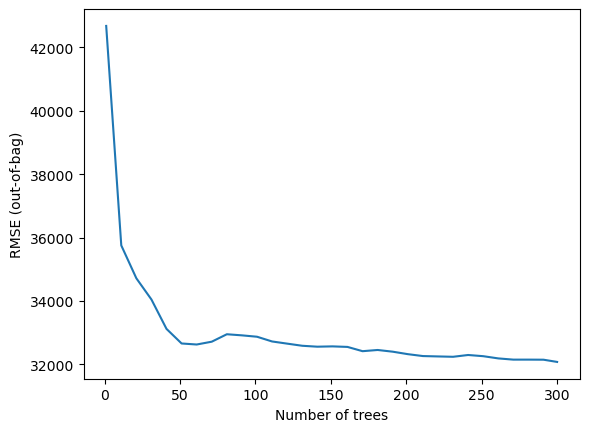

In [20]:
# yeni modelin kayıp çıktılarının görselleştirilmesi
logs = rf_best10.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [21]:
# farklı bir yol deniyelim ------------------------------------------------------------------------------
# farklı model kullanmak için ham veriyi tekrar aldım
test_df.drop(['Id'], axis=1, inplace=True)

In [22]:
# bazı aykırı verilerden temizledim ve satış fiyatı özniteliğinin logaritmasını alarak değerleri küçülttüm
train = train_df[train_df.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

/tmp/ipykernel_32/1601667645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["SalePrice"] = np.log1p(train["SalePrice"])


In [23]:
# veri işlemeyi 2 kere tekrar etmemek için rain ve test verilerini birleştirdim ve tek bir tablo elde ettim
train_features = train.drop(['SalePrice'], axis=1)
test_features = test_df
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [24]:
features.shape

(2917, 79)

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

In [26]:
# bazı sütunların tip ayarlamalarını yaptım ve Nan olan bazı değerleri uygun gördüğüm şekilde doldurdum
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [27]:
# Nan değerlerin doldurulmasının devamı (başka sütunlar için)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [28]:
# tablodaki ilk 4 verinin gösterilmesi
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,NaN,NaN,0,12,2008,WD,Normal


In [29]:
# LotFrontage özniteliğini Neighborhood özniteliğine göre gurupladım ve medyanlarını alarak boş olan değerleri doldurudum
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# sayılsal olan diğer sütunların boş değerlerine sıfır değeri atadım
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [30]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# numerik değerleri en iyi şekilde doldurma yöntemlerinden biri 
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [31]:
# Gereksiz gördüğüm 3 özniteliği kaldırdım
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [32]:
# yeni öznitelikler elde ettim. Örneğin havuz var mı yoksa yokmu. Varsa 1 yoksa 0 atadım
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [33]:
features.shape

(2917, 81)

In [34]:
# kategorik değişkenleri sayısal değişkene dönüştürdüm (kısaca one hot encoder işlemini yaptım)
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 328)

In [35]:
# düzenleme işlemi için birleştirdiğim train ve test tablolarını tekrar ayırdım

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 328), (1458,), (1459, 328))

In [36]:
# sürekli aynı sonuçların olduğu sütunlar kontrol ediliyor. Böyle bir öznitelik varsa kaldırılıyor

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [37]:
X.shape, y.shape, X_sub.shape

((1458, 327), (1458,), (1459, 327))

In [38]:
from sklearn.model_selection import KFold, cross_val_score

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [39]:
# tahmin için bir LGBMRegressor modeli oluşturdum
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [40]:
# modeli eğitime soktum
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

lightgbm
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


In [41]:
# ek olarak birde tensorflowda nasıl sonuç vericeğini görmek istedim. Bu yüzden veriyi ilk başta bölerek tensorflow için hazırladım
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.05,
                                                    random_state=0)
scaler = RobustScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# verileri tensöre çevirdim
X_train=tf.convert_to_tensor(X_train_scaled,np.float64)
Y_train=tf.convert_to_tensor(Y_train,np.float64)

X_test=tf.convert_to_tensor(X_test_scaled,np.float64)
Y_test=tf.convert_to_tensor(Y_test,np.float64)

In [43]:
# tensorflow modelimi oluşturdum.

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(327, )),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

In [44]:
# tensorflow modelini eğittim
history = model.fit(
    X_train, 
    Y_train, 
    epochs=40, 
    batch_size=4096,
    verbose=1, 
    shuffle=True,
    validation_split=0.4)

Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 134.6813 - mean_squared_error: 134.6813 - val_loss: 117.6354 - val_mean_squared_error: 117.6354
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 116.4875 - mean_squared_error: 116.4875 - val_loss: 101.4080 - val_mean_squared_error: 101.4080
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 99.8459 - mean_squared_error: 99.8459 - val_loss: 86.8441 - val_mean_squared_error: 86.8441
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 85.7652 - mean_squared_error: 85.7652 - val_loss: 73.9426 - val_mean_squared_error: 73.9426
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 73.0935 - mean_squared_error: 73.0935 - val_loss: 62.6806 - val_mean_squared_error: 62.6806
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 61.7388 - mean_squared_error: 61.7388 - val_loss: 53.0428 - val_mean_squared_error: 53.0428
Epoch 7/40
1/1 [

Text(0.5, 1.0, 'Training and validation loss')

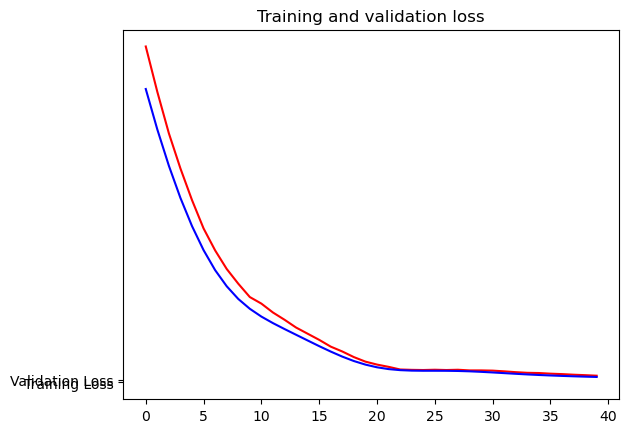

In [45]:
# tensorflow modelinin kayıp grafiğini çizdirdim
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#list of list results on training and test data
# sets for each training epoch

val_acc=history.history['val_mean_squared_error']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(40) # Get number of epochs


# Plotting training and validation loss per epoch

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')